In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from math import log
import numpy as np
from sklearn.preprocessing import normalize

In [2]:
data = pd.read_pickle("../data/processed/supply_and_demand_order_level.pkl")
data

,lineage,kingdom,phylum,class,order,nr_authors,taxonomicResearchNeeded,cropWildRelatives,horizonInvasives,birdDir,habitatsDir,marineDir,iasListConcern,pollinators,redlistFull
0,Root;k__Animalia;p__Arthropoda;c__Insecta;o__D...,Animalia,Arthropoda,Insecta,Diptera,6622.0,35.0,0.0,1.0,0.0,1.0,0.0,0.0,901.0,0.0
1,Root;k__Animalia;p__Arthropoda;c__Insecta;o__H...,Animalia,Arthropoda,Insecta,Hemiptera,3866.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Root;k__Animalia;p__Arthropoda;c__Maxillopoda;...,Animalia,Arthropoda,Maxillopoda,Sessilia,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Root;k__Animalia;p__Chordata;c__;o__Perciformes,Animalia,Chordata,NaN,Perciformes,1039.0,32.0,0.0,8.0,0.0,15.0,62.0,4.0,0.0,24.0
4,Root;k__Animalia;p__Arthropoda;c__Malacostraca...,Animalia,Arthropoda,Malacostraca,Decapoda,578.0,0.0,0.0,7.0,0.0,4.0,0.0,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,Root;k__Fungi;p__Blastocladiomycota;c__;o__,Fungi,Blastocladiomycota,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1638,Root;k__Fungi;p__Sanchytriomycota;c__Sanchytri...,Fungi,Sanchytriomycota,Sanchytriomycetes,Sanchytriales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1639,Root;k__Fungi;p__Ascomycota;c__Archaeorhizomyc...,Fungi,Ascomycota,Archaeorhizomycetes,Archaeorhizomycetales,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1640,Root;k__Chromista;p__Cryptophyta;c__Cryptophyc...,Chromista,Cryptophyta,Cryptophyceae,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
plants = data[data["kingdom"]=="Plantae"]
animals = data[data["kingdom"]=="Animalia"]
fungi = data[data["kingdom"]=="Fungi"]

In [20]:
def scatter_supply_single_demand(df, demand, col="blue",
                                 logx=False, logy=False, 
                                 nozerosy=False, trendline=False, 
                                 xmin=0, ymin=0,
                                 ax=None):  # <- added ax parameter
    # Filter zeros
    if nozerosy:
        df = df[df[demand] != 0]

    # Set x and y
    if logx:
        x = np.log(df["nr_authors"] + 1)
        xlabel = "log(Researchers + 1)"
    else:
        x = df["nr_authors"]
        xlabel = "Researchers"

    if logy:
        y = np.log(df[demand] + 1)
        ylabel = f"log({demand} + 1)"
    else:
        y = df[demand]
        ylabel = demand

    # Create plot axis if not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Plot points
    ax.scatter(x, y, c=col)

    # Trendline
    if trendline:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), color=col)

    # Labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Annotations
    for i, txt in enumerate(df["order"]):
        if x.iloc[i] >= xmin and y.iloc[i] >= ymin:
            ax.annotate(txt, (x.iloc[i], y.iloc[i]),
                        ha="left", rotation=30, fontsize=7)

In [21]:
def scatter_combined_demand(df, demands, col="blue",
                            logx=False, nozeros=False, trendline=False,
                            xmin=0, ymin=0):
    # SET X AND Y
    if nozeros: # removes data points with both x=0 and y=0
        df = df[["order", "nr_authors", demand]].loc[(df!=0).any(axis=1)]
    
    # x: logged or not
    if logx: 
        x = np.log(list(df["nr_authors"]+1))
        xlabel = "log(Researchers + 1)"
    else: 
        x = list(df["nr_authors"])
        xlabel = "Researchers"
    
    # y: combined normalized demands
    comb_demands = len(df)*[0,]
    for demand in demands:
        norm_demand = normalize([df[demand]])[0]
        comb_demands = [comb_demands[i] + norm_demand[i] for i in range(len(comb_demands))]
    
    y = comb_demands
    
    # PLOT
    fig, ax = plt.subplots()
    ax.scatter(x,y,c=col)
    
    if trendline:
        z = np.polyfit(x,y,1)
        p = np.poly1d(z)
        plt.plot(x, p(x))
        
    # add labels 
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Combined normalized demands")
    
    for i, txt in enumerate(df["order"]):
        if x[i] >= xmin and y[i] >= ymin:
            ax.annotate(txt, (x[i],y[i]),
                        ha="left", rotation=30, fontsize=7)

# Plants

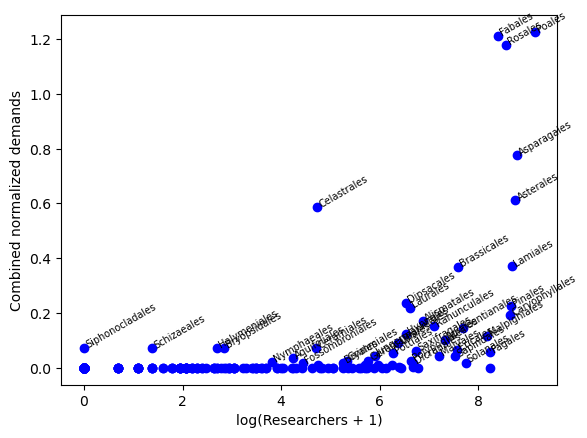

In [22]:
scatter_combined_demand(plants, ["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"],
                        logx=True, ymin=0.01)

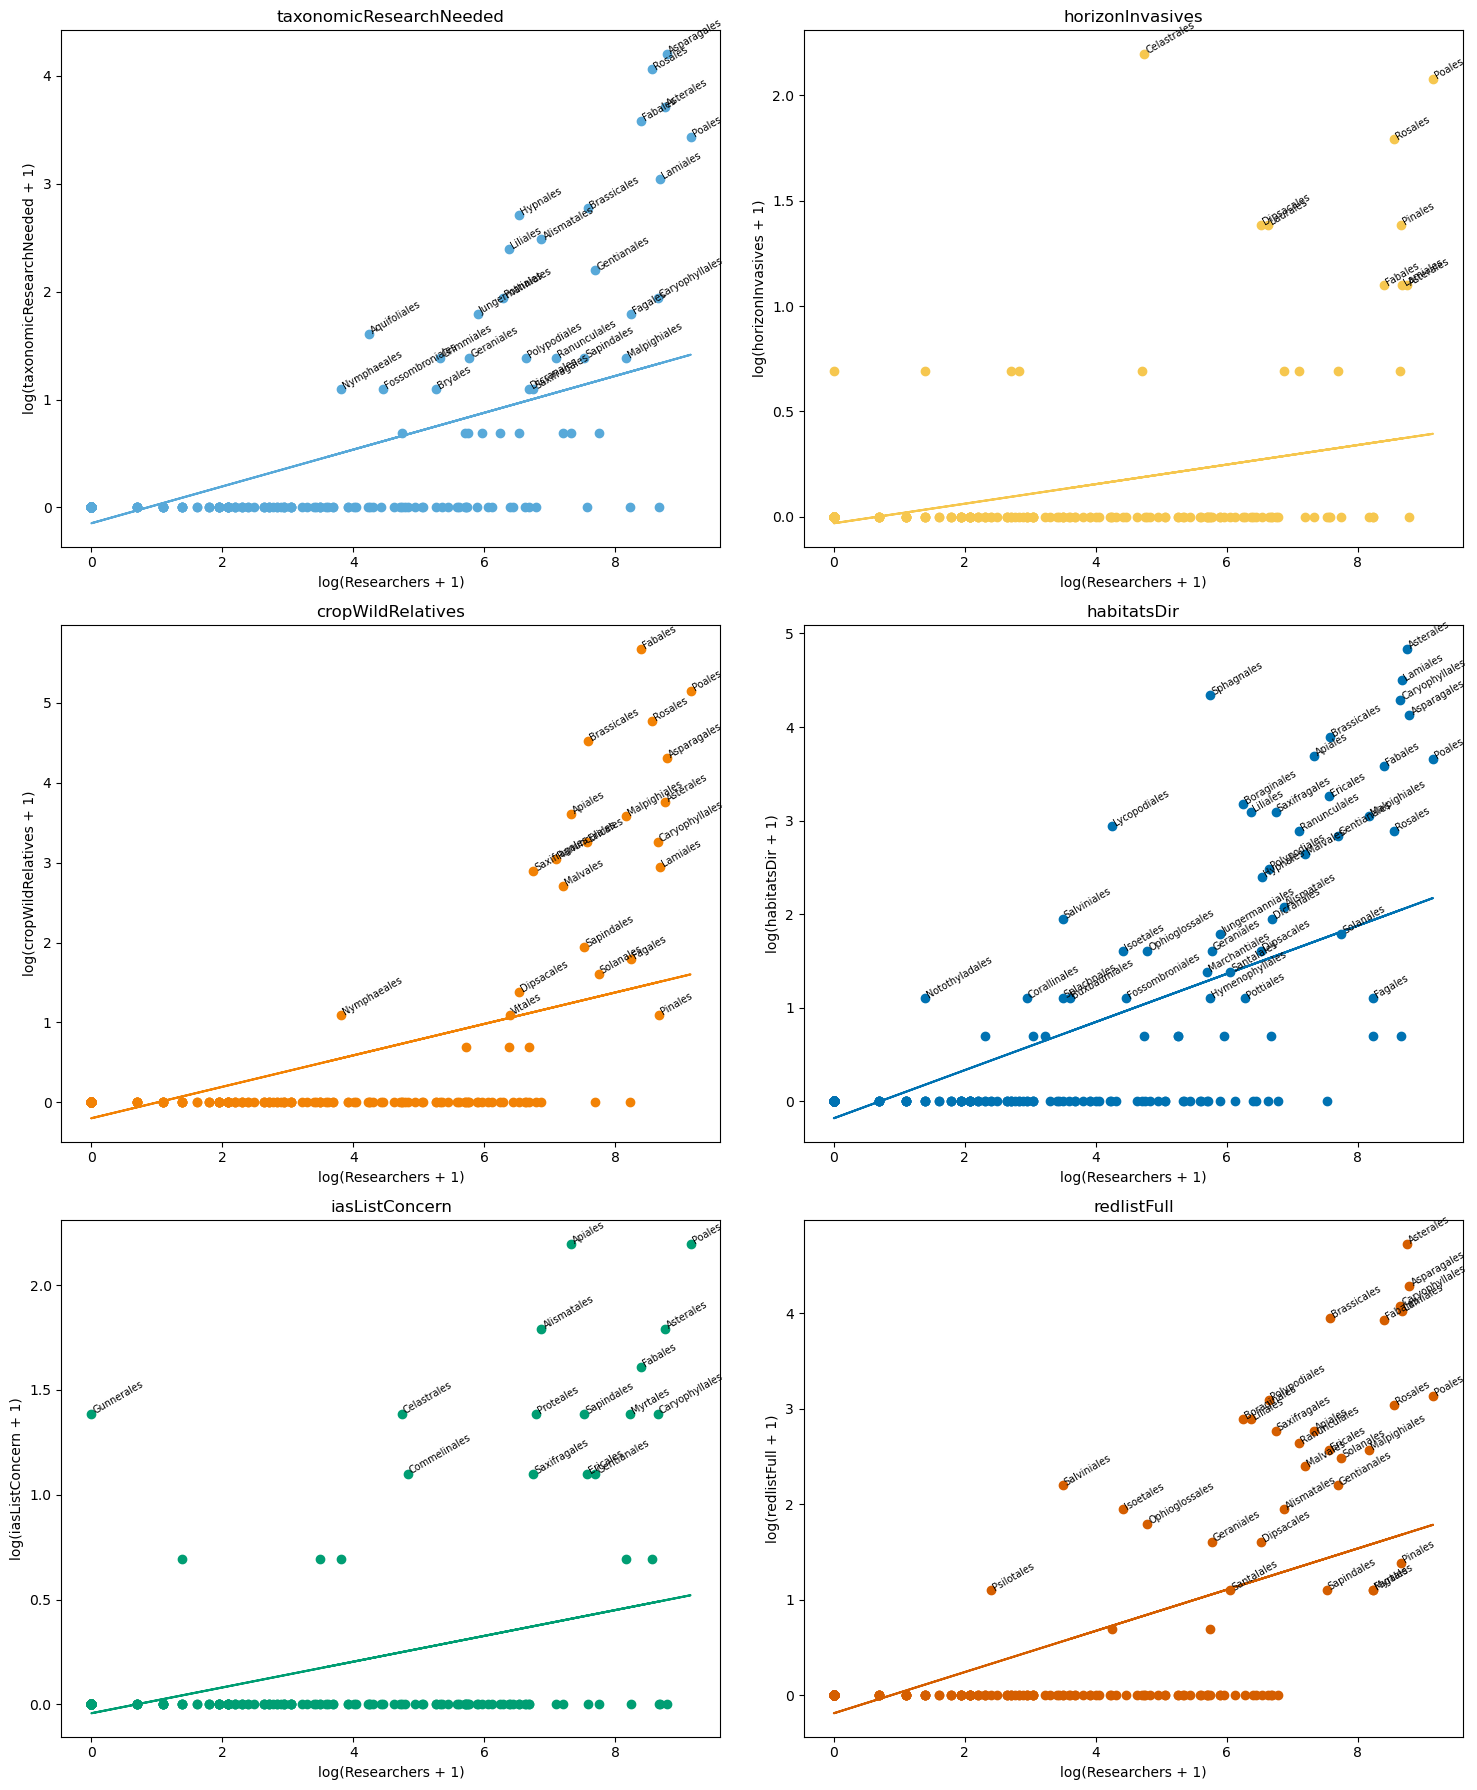

In [51]:
# Set up 2x3 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 18))  # Adjust figsize as needed

# Flatten axes for easy indexing
axes = axes.flatten()

# Define your demands and colours
demands = ["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives",
           "habitatsDir", "iasListConcern", "redlistFull"]

colors = ["#58A9D9", "#F6C74F", "#F28205", "#0072B2", "#009E73", "#D55E00"]

# Loop through each demand and corresponding axis
for i, (demand, ax) in enumerate(zip(demands, axes)):
    color = colors[i]
    scatter_supply_single_demand(
        plants, demand,
        col=color,
        logx=True, logy=True,
        trendline=True,
        ymin=1,
        ax=ax  # Make sure your function accepts this
    )
    ax.set_title(demand)  # Optional: Add a title per panel

# Adjust layout
plt.tight_layout()
plt.savefig("supply_demand_panel_plants.png", dpi=300, bbox_inches="tight")
plt.show()

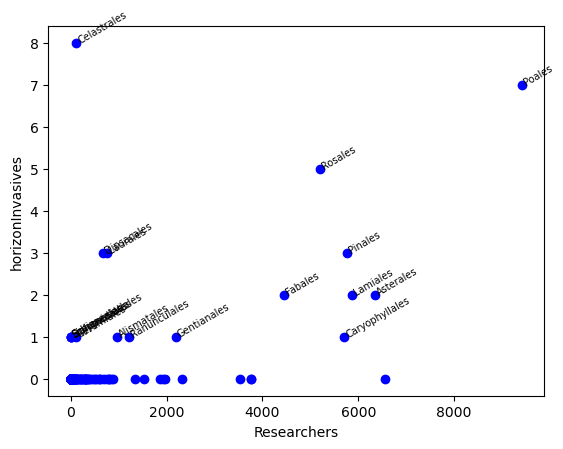

In [8]:
scatter_supply_single_demand(plants, "horizonInvasives", logx=False, ymin=1)

Text(0, 0.5, 'Normalized demands')

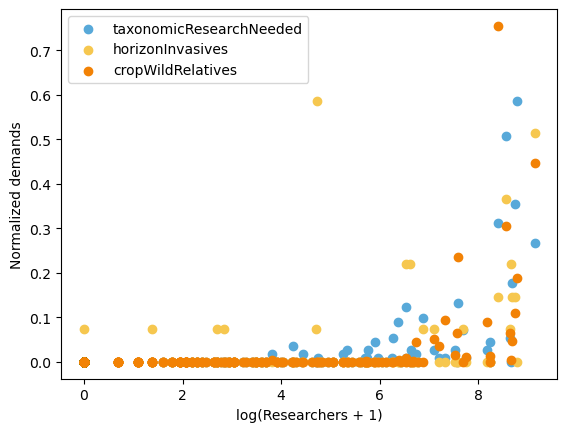

In [9]:
x = np.log(list(plants["nr_authors"]+1))
fig, ax = plt.subplots()
for i, demand in enumerate(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"]):
    color = ["#58A9D9", "#F6C74F", "#F28205"][i]
    y = normalize([list(plants[demand])])
    ax.scatter(x,y,c=color)
ax.legend(["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"])
ax.set_xlabel("log(Researchers + 1)")
ax.set_ylabel("Normalized demands")

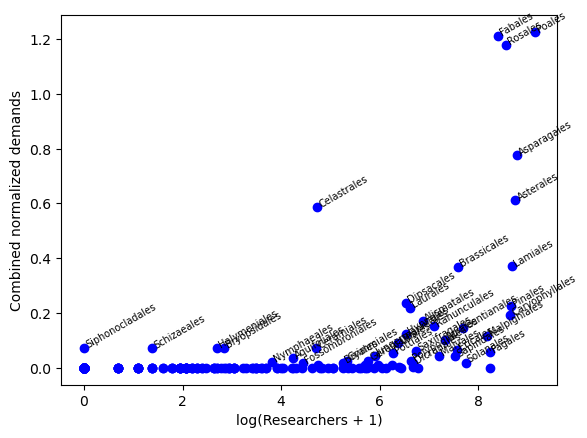

In [10]:
scatter_combined_demand(plants, ["taxonomicResearchNeeded", "horizonInvasives", "cropWildRelatives"],
                        logx=True, ymin=0.01)

# Animals

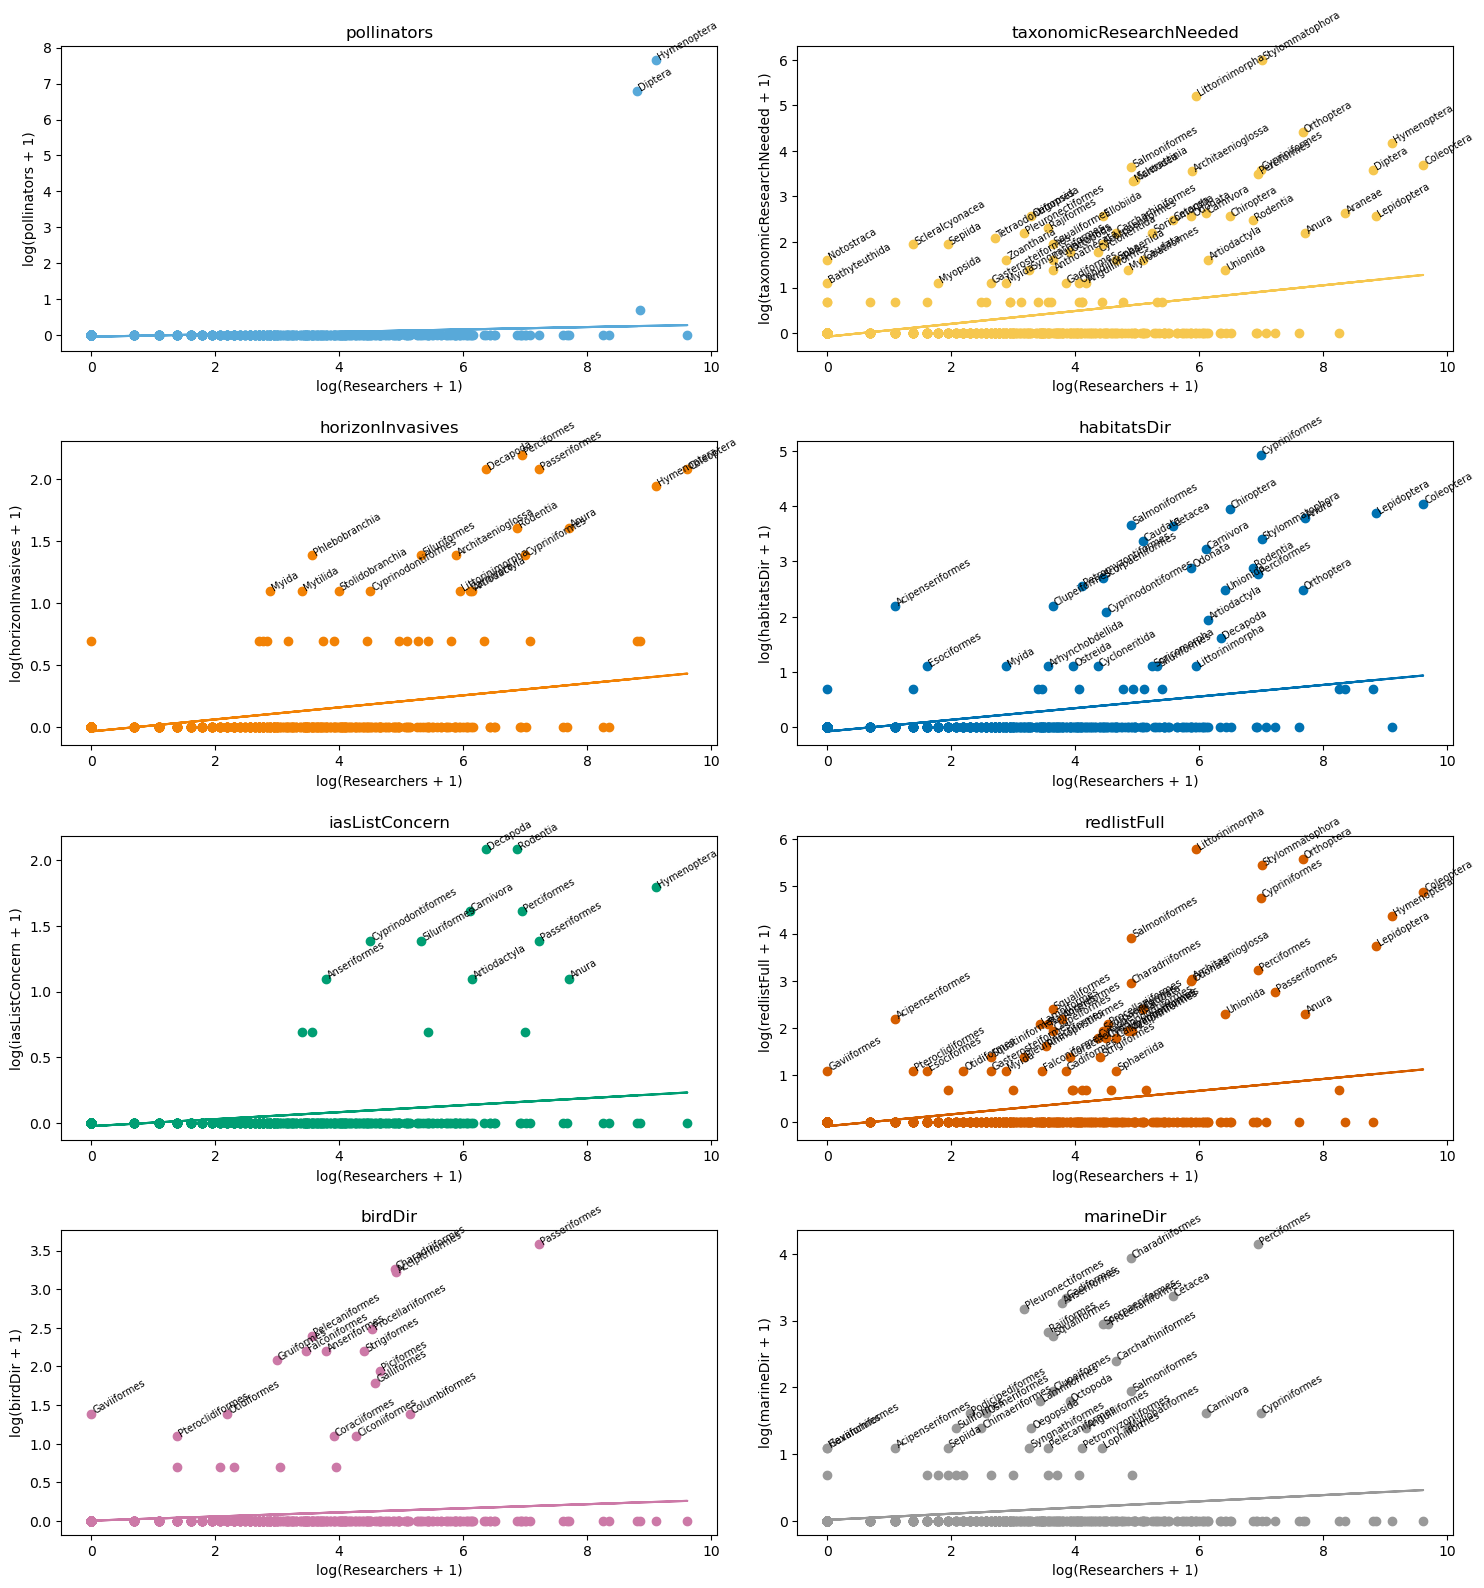

In [49]:
# Set up 2x3 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(15, 16))  # Adjust figsize as needed

# Flatten axes for easy indexing
axes = axes.flatten()

# Define your demands and colours
demands = ["pollinators", "taxonomicResearchNeeded", "horizonInvasives", "habitatsDir", "iasListConcern", "redlistFull", "birdDir", "marineDir"]

colors = ["#58A9D9", "#F6C74F", "#F28205", "#0072B2", "#009E73", "#D55E00", "#CC79A7", "#999999"]

# Loop through each demand and corresponding axis
# Loop through each demand and corresponding axis
for i, (demand, ax) in enumerate(zip(demands, axes)):
    scatter_supply_single_demand(
        animals, demand,
        col=colors[i],
        logx=True, logy=True,
        trendline=True,
        ymin=1,
        ax=ax
    )
    ax.set_title(demand)  # Optional: Add a title per panel

# Adjust layout
plt.tight_layout()
plt.savefig("supply_demand_panel_animals.png", dpi=300, bbox_inches="tight")
plt.show()

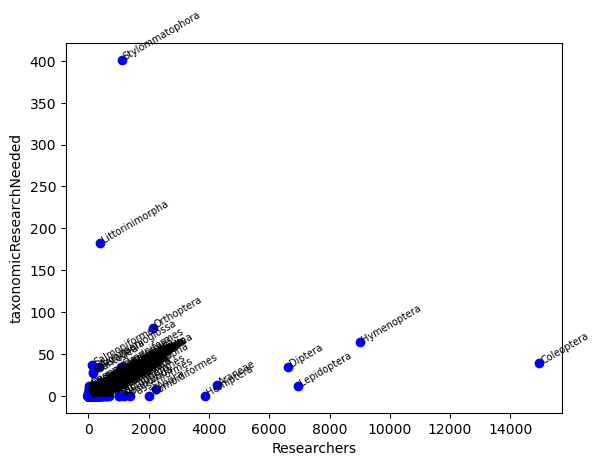

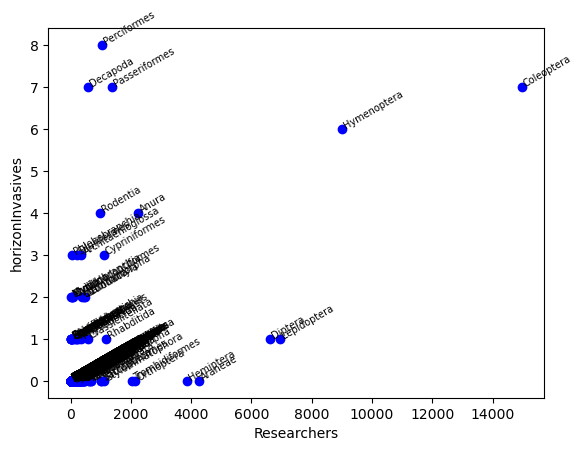

In [11]:
for demand in ["taxonomicResearchNeeded", "horizonInvasives"]:
    scatter_supply_single_demand(animals, demand)

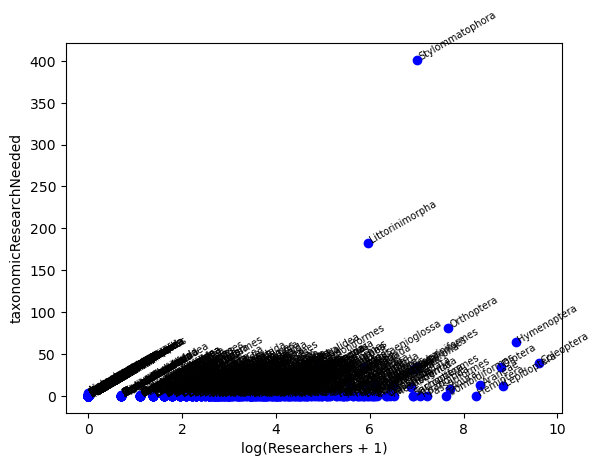

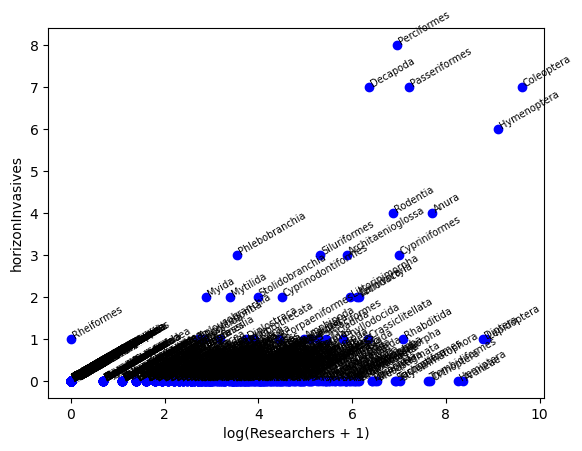

In [12]:
for demand in ["taxonomicResearchNeeded", "horizonInvasives"]:
    scatter_supply_single_demand(animals, demand, logx=True)

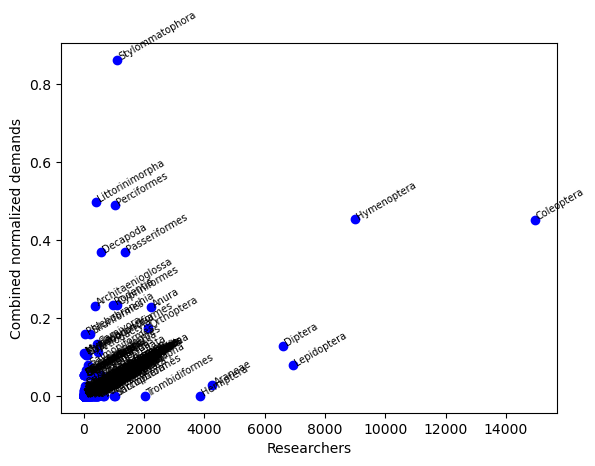

In [13]:
scatter_combined_demand(animals, ["taxonomicResearchNeeded", "horizonInvasives"])

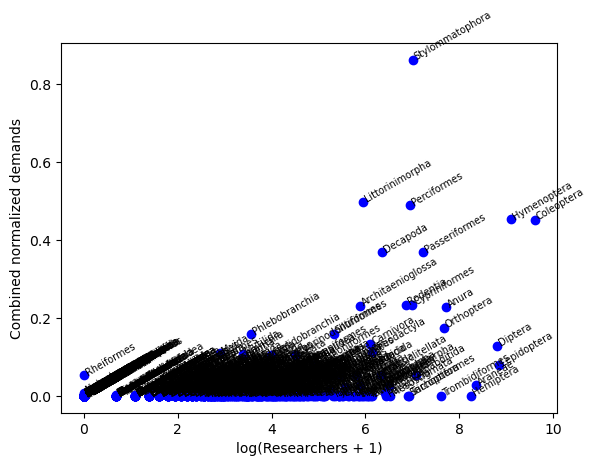

In [14]:
scatter_combined_demand(animals, ["taxonomicResearchNeeded", "horizonInvasives"],
                       logx=True)

# Fungi

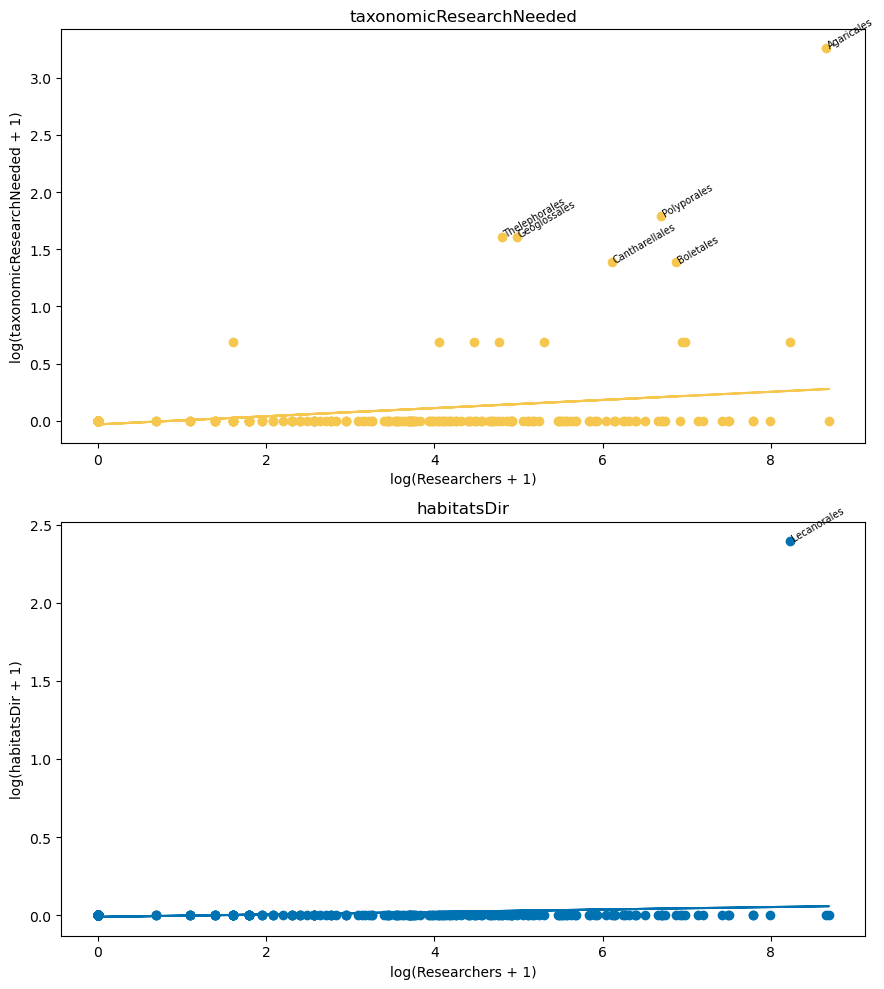

In [47]:
# Set up 2x3 subplot grid
fig, axes = plt.subplots(2, 1, figsize=(9, 10))  # Adjust figsize as needed

# Flatten axes for easy indexing
axes = axes.flatten()

# Define your demands and colours
demands = ["taxonomicResearchNeeded", "habitatsDir"]

colors = ["#F6C74F", "#0072B2", "#009E73", "#D55E00"]

# Loop through each demand and corresponding axis
# Loop through each demand and corresponding axis
for i, (demand, ax) in enumerate(zip(demands, axes)):
    scatter_supply_single_demand(
        fungi, demand,
        col=colors[i],
        logx=True, logy=True,
        trendline=True,
        ymin=1,
        ax=ax
    )
    ax.set_title(demand)  # Optional: Add a title per panel

# Adjust layout
plt.tight_layout()
plt.savefig("supply_demand_panel_fungi.png", dpi=300, bbox_inches="tight")
plt.show()

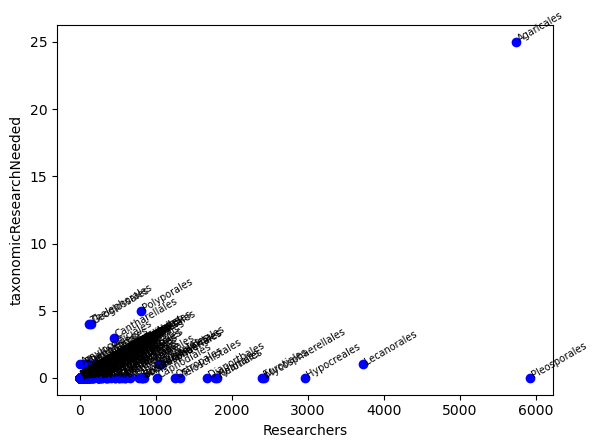

In [15]:
scatter_supply_single_demand(fungi, "taxonomicResearchNeeded")

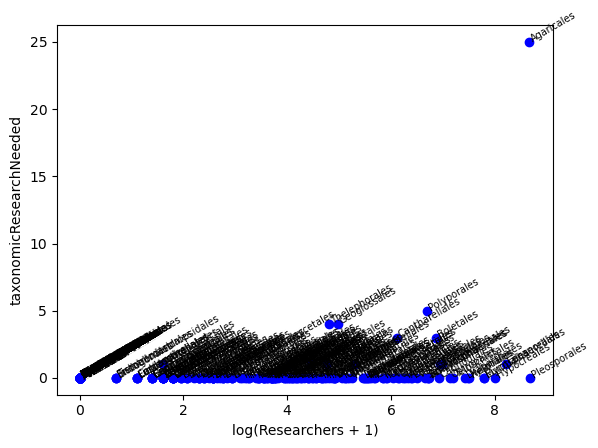

In [16]:
scatter_supply_single_demand(fungi, "taxonomicResearchNeeded", 
                             logx=True)